 # Machine Learning Project

 Kalin Gibbons

 Due: May 7, 2020
 ## Introduction

 ---

 Outcomes of total knee arthroplasty (TKA) are dependent on surgical
 technique, patient variability, and implant design. Poor surgical or design
 choices can lead to undesirable contact mechanics and joint kinematics,
 including poor joint alignment, instability, and reduced range of motion. Of
 these three factors, implant design and surgical alignment are within our
 control, and there is a need for robust implant designs that can accommodate
 variability within the patient population. One of the tools used to evaluate
 implant designs is simulation through finite element analysis (FEM), which
 offers considerable early design-stage speedups when compared to traditional
 prototyping and mechanical testing. Nevertheless, the usage of FEM predicates
 a considerable amount of software and engineering knowledge, and it can take
 a great deal of time, compute or otherwise, to generate and analyse results.
 Currently used hardware and software combinations can take anywhere from 4 to
 24 hours to run a single simulation of one daily-living task, for a
 moderately complex knee model. A possible solution to this problem is to use
 the FEM results to train predictive machine learning regression models
 capable of quickly  iterating over a number of potential designs. Such models
 could be used to hone in on a subset of potential designs worthy of further
 investigation.
 ### Data Description

 This _training_ dataset is generated from simplified finite element models of
 a cruciate-sacrificing, post and cam driven knee implant performing a
 deep-knee-bend. The implant geometries and surgical alignments are
 parameterized by 13 predictor variables which were drawn using Latin
 hypercube sampling from a range of currently used manufacturer dimensions,
 and angles performed during successful surgeries. There were originally 15
 predictors for this dataset, but two were fixed at average values for this
 particular batch of simulations. For the test dataset, the same predictors
 were uniformly drawn across the ranges of potential values.

In [1]:
import scipy.io as spio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path
from scipy import signal
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  Ridge)
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error



In [2]:
plt.rcParams['figure.figsize'] = (9, 5.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Times New Roman'
final_run = False




 ## Data Cleaning

 ---

 We can begin by loading the datasets from MATLAB binary files. Following that
 we can take a look at the predictor distributions within the training and
 test sets, and confirm that the Latin hypercube and uniform sampling
 successfully covered the design space.

,fem_rad_dist,fem_rad_post,fem_rad_cor,tib_ant_conf,tib_post_conf,tib_cor_conf,troch_ang,troch_offset,fem_ie,fem_vv,tib_slope,tib_ie,tib_vv
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,34.679318,34.699880,25.076654,0.576447,0.566606,0.566455,12.136250,0.114613,2.500913,3.022945,5.425695,3.085065,2.661978
std,8.758003,8.621422,5.704977,0.250227,0.238158,0.245048,2.824428,1.712926,1.642112,2.274754,3.234259,6.989610,2.581382
min,20.023275,20.147794,15.057473,0.156412,0.155033,0.156521,7.041533,-2.971073,-0.170765,-0.783379,0.036042,-9.262953,-1.779404
25%,27.041186,27.269871,20.366485,0.354636,0.361475,0.359228,9.843074,-1.294510,1.075247,1.088741,2.620300,-2.984869,0.510166
50%,34.258993,34.511098,25.152767,0.575742,0.563610,0.562852,12.127442,0.174195,2.387321,2.952512,5.342771,2.959171,2.601794
75%,41.952856,42.077240,29.869907,0.791103,0.766385,0.781211,14.543464,1.525529,3.916163,4.921073,8.030905,8.935175,4.867703
max,49.991960,49.856998,34.874884,0.996963,0.987700,0.998975,16.950999,2.959107,5.361260,7.158789,11.128010,15.324681,7.176948


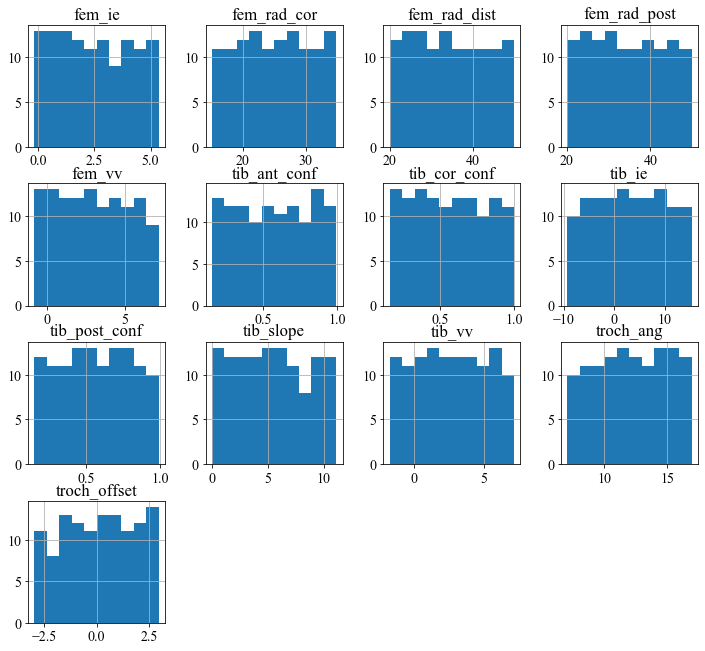

In [3]:
# Load the test data
def import_data(matfilepath):
    data = spio.loadmat(matfilepath, squeeze_me=True)
    keys = list(data.keys())
    data = data[keys[-1]]
    columns = list(map(lambda x: x.lower(), data.dtype.names))
    old = ['femie', 'femvv', 'tibslope', 'tibie', 'tibvv', 'xn', 'ctf', 'ctm']
    new = ['fem_ie', 'fem_vv', 'tib_slope', 'tib_ie', 'tib_vv', 'cop_', 'force_',
        'torque_']
    for idx, (o, n) in enumerate(zip(old, new)):
        columns = list(map(lambda x: x.replace(o, n), columns))

    data_df = pd.DataFrame(data)
    data_df.columns = columns
    return data_df


def split_df(df, predictor_index):
    every_index = np.arange(df.shape[1])
    response_index = np.setdiff1d(every_index, predictor_index)
    pred_df = df.iloc[:, predictor_index].drop(columns=['cam_rad'])  # constant
    resp_df = df.iloc[:, response_index]
    return pred_df.astype(np.float), resp_df


def remove_failed(response_series, objs):
    failed_idx = response_series.apply(lambda x: x.size == 0)
    new_objs = np.full_like(objs, np.nan)
    for idx, obj in enumerate(objs):
        new_objs[idx] = obj[~failed_idx]

    return new_objs


# Import the data, split predictors from response
test_df = import_data('./data/test_reduced.mat')
train_df = import_data('./data/doe_reduced.mat')
pred_idx = np.arange(0, 14)
test_feat_df, test_resp_df = split_df(test_df, pred_idx)
train_feat_df, train_resp_df = split_df(train_df, pred_idx)

# Failed simulations will have empty rows. Remove them.
t = test_resp_df['time']
test_resp_df, test_feat_df = remove_failed(t, (test_resp_df, test_feat_df))
t = train_resp_df['time']
train_resp_df, train_feat_df = remove_failed(t, (train_resp_df, train_feat_df))
del(t)

# Describe the design space
train_feat_df.hist(figsize=(12, 11))
train_feat_df.describe()



,fem_rad_dist,fem_rad_post,fem_rad_cor,tib_ant_conf,tib_post_conf,tib_cor_conf,troch_ang,troch_offset,fem_ie,fem_vv,tib_slope,tib_ie,tib_vv
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.00000
mean,36.721494,33.921034,24.979885,0.562414,0.560000,0.579770,12.434598,-0.134368,2.234943,3.218851,5.608621,3.899770,2.98977
std,8.744665,8.471627,5.585225,0.251807,0.199884,0.227484,3.100123,1.744195,1.441232,2.176192,3.220880,6.935808,2.67016
min,20.360000,20.140000,15.570000,0.160000,0.160000,0.170000,7.010000,-2.920000,0.130000,-0.640000,0.200000,-9.160000,-1.61000
25%,28.465000,26.270000,19.980000,0.330000,0.390000,0.380000,9.275000,-1.785000,0.925000,1.390000,2.875000,-1.240000,0.77500
50%,37.560000,33.280000,24.770000,0.560000,0.550000,0.590000,12.860000,-0.090000,2.070000,2.860000,5.730000,4.420000,3.14000
75%,43.935000,41.315000,29.515000,0.765000,0.720000,0.785000,15.435000,1.430000,3.520000,5.145000,8.130000,9.670000,5.37500
max,49.120000,49.880000,34.590000,1.000000,0.950000,0.990000,16.900000,2.970000,5.200000,7.100000,11.170000,15.340000,7.06000


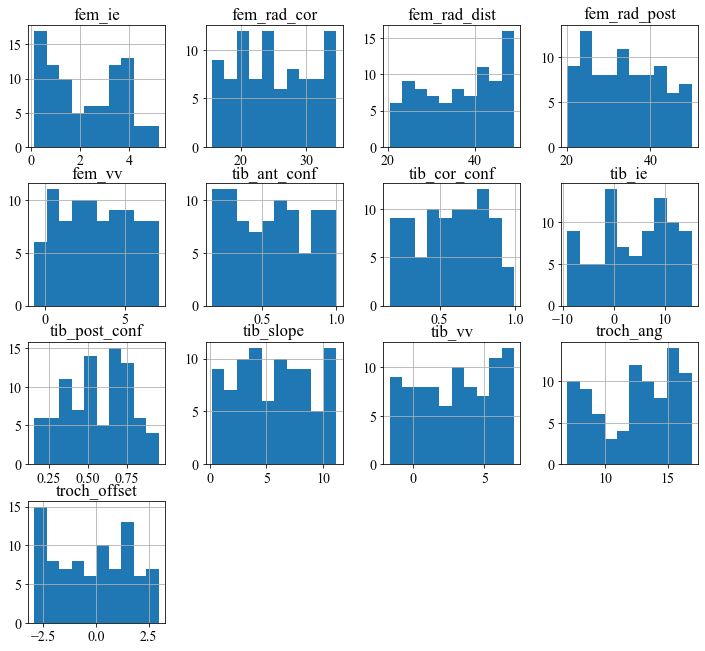

In [4]:
# Describe the test space
test_feat_df.hist(figsize=(12, 11))
test_feat_df.describe()




 It looks like the LHS did a good job of covering all of the design space for
 our training set, but our histograms are looking less uniform for the testing
 set. The parameter for the offset of the trochlear groove in particular seem
 right-skewed. We can lean on domain knowledge to guess that a positive offset
 lead to more simulation failures, which we have already removed. This makes
 sense because your trochlear groove is a smooth asymmetrical surface that
 your patella (kneecap) rides in, and moving this in a way that compounds the
 effect of asymmetrical vasti muscle distribution would increase the
 likelihood of patellar dislocation during, making simulated patient fail to
 complete their deep-knee-bend. A negative offset most likely reduced the risk
 of these dislocations, while a positive offset had the opposite effect. We'll
 skip going back and checking the histograms before removing the empty rows;
 that's a problem for the FEA modeler.
 ### Ranking Feature Importances

 This dataset began with 15 features, but cam radius and femoral
 flexion-extension were removed after being found to be the least important.
 Let's check how the other features rank.

In [5]:
def collect_response(response_series):
    return np.vstack(response_series.ravel())


feats = train_feat_df.columns
imps = np.zeros_like(feats, dtype=np.float)
imps_std = imps.copy()
X = StandardScaler().fit_transform(train_feat_df.values)
for col_name, col in train_resp_df.iteritems():
    y = collect_response(col)
    forest = RandomForestRegressor().fit(X, y)
    imps = imps + forest.feature_importances_
    imps_std = imps_std + np.std(
        [tree.feature_importances_ for tree in forest.estimators_], axis=0
    )
imps = imps / train_resp_df.shape[1]
imps_std = imps_std / train_resp_df.shape[1]

indices = np.argsort(imps)[::-1]



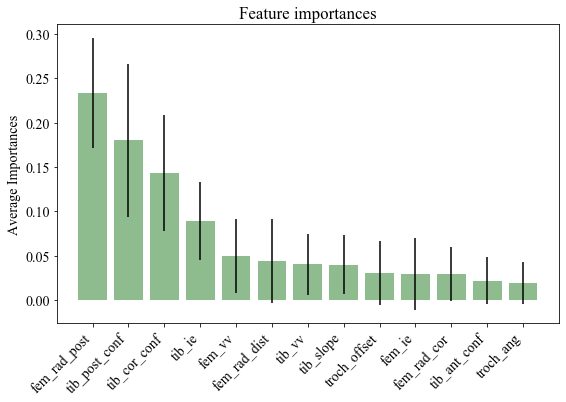

In [6]:
plt.figure()
plt.title('Feature importances')
plt.bar(range(X.shape[1]), imps[indices], yerr=imps_std[indices],
        color='DarkSeaGreen', align='center')
plt.xticks(range(X.shape[1]), feats[indices], rotation=45, ha='right')
plt.xlim([-1, X.shape[1]])
plt.ylabel('Average Importances')
plt.show()




 This dataset has been truncated to only include contact mechanics and joint
 loads response data, and we're seeing posterior femoral radius and tibial
 conformity ratios as being the most important, followed by internal-external
 alignment of the tibial insert. This makes sense because the majority of our
 contact mechanics response variables concern the center of pressure
 ordinates, and the area of contact between the femoral component and the
 plastic tibial spacer.

 Some of those features don't seem very important. Let's try running principal
 component analysis on this dataset to see how quickly we're capturing
 variance.

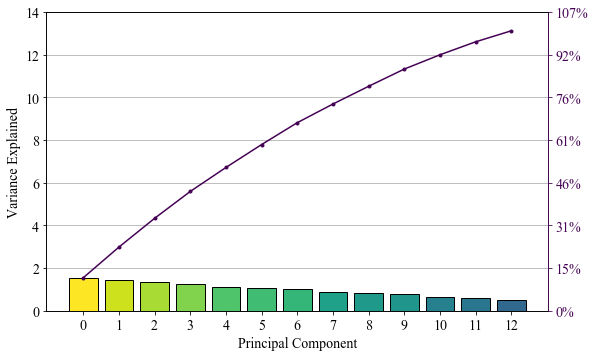

In [7]:
def pareto(heights, cmap=None, names=None):
    fig = plt.gcf()
    ax = fig.add_subplot(1, 1, 1)
    ax.grid(which='major', axis='y')
    ax.set_axisbelow(True)
    ysum = np.sum(heights)

    # Create the bar plot
    bar_ticks = range(len(heights))
    data_color = [height / max(heights) for height in heights]
    colormap = plt.cm.get_cmap()
    colors = colormap(data_color)
    if cmap is not None:
        colormap = plt.cm.get_cmap(cmap)
        colors = colormap(data_color)
        sm = ScalarMappable(cmap=colormap, norm=plt.Normalize(0, max(data_color)))
        sm.set_array([])
        bar = ax.bar(bar_ticks, heights, color=colors, edgecolor='k',
                     tick_label=names)
    else:
        bar = ax.bar(bar_ticks, heights, edgecolor='k', tick_label=names)

    # Format the bar axis
    ax.set_xticks(bar_ticks)
    if names is not None:
        plt.xticks(rotation=45, ha='right')
    ax.set_ylim((0, ysum))
    yticks = ax.get_yticks()
    if max(yticks) < 0.9 * ysum:
        yticks = np.unique(np.append(yticks, ysum))
    ax.set_yticks(yticks)
    ylim = ax.get_ylim()

    # Add an axes for the cumulative sum
    ax2 = plt.twinx()
    lin = ax2.plot(bar_ticks, np.cumsum(heights), '.-', color=colormap(0))
    ax2.set_ylim(ylim)
    ax2.spines['right'].set_color(colormap(0))
    ax2.tick_params(axis='y', colors=colormap(0))
    ax2.title.set_color(colormap(0))
    fig.canvas.draw()
    yticks = ax2.get_yticks()
    yticks = np.round(yticks / ysum * 100).astype(np.int)
    labels = [str(yt) + '%' for yt in yticks]
    ax2.set_yticklabels(labels)
    return (bar, lin), (ax, ax2)


X = StandardScaler().fit_transform(train_feat_df.values)
pca = PCA(n_components=feats.size)
pca.fit(X)
_, ax = pareto(pca.explained_variance_, cmap='viridis')
ax[0].set_ylabel('Variance Explained')
ax[0].set_xlabel('Principal Component')
plt.show()



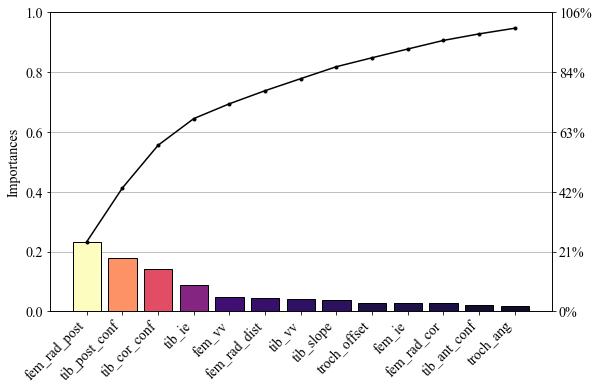

In [8]:
_, ax = pareto(imps[indices], cmap='magma', names=feats[indices])
ax[0].set_ylabel('Importances')
plt.show()




 Looks like each variable is contributing about the same amount to the overall
 variance of this feature data, but we've picked up about 80% of the
 importance by the sixth feature. We're performing regression instead of
 classification, so the importance plots holds more weight for our use case.
 We'll leave them in because I want to make a comparison to some earlier
 results from looking at this problem in 2017.
 ## Regression

 ---

 Now that we understand our data, let's see if we can predict the output
 values. We're going to skip splitting into a develop-validate-test set for
 this example project, again so I can compare to earlier results.

In [9]:
# Choose the response of interest
resp_name = 'lat_force_1'

# Get the data ready
X_train = train_feat_df.to_numpy()
X_test = test_feat_df.to_numpy()
y_train = collect_response(train_resp_df[resp_name])
y_test = collect_response(test_resp_df[resp_name])


# Scale the data
scaler = StandardScaler
transformer = scaler().fit(X_train)
X_train_scaled = transformer.transform(X_train)
X_test_scaled = transformer.transform(X_test)

# Select a model to investigate
names = ('grad_boost', 'rand_forest', 'adaboost_tree', 'adaboost_linear',
         'decision_tree', 'linear')
learners = (
    GradientBoostingRegressor(n_estimators=100),
    RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=100),
    AdaBoostRegressor(LinearRegression(), n_estimators=100),
    DecisionTreeRegressor(),
    LinearRegression()
)
errs = np.zeros_like(names, dtype=np.float)
for idx, learner in enumerate(learners):
    regr = MultiOutputRegressor(learner)
    regr.fit(X_train_scaled, y_train)
    y_pred = regr.predict(X_test_scaled)
    errs[idx] = mean_squared_error(y_test, y_pred)

results = pd.Series(errs, index=names)
results



grad_boost          6364.092033
rand_forest         6419.391763
adaboost_tree       6325.878917
adaboost_linear     7616.931743
decision_tree      15887.169267
linear              4954.746461
dtype: float64


 Looks like the ordinary linear regression had the smallest errors. Let's take
 a look at the plots and see how it does.

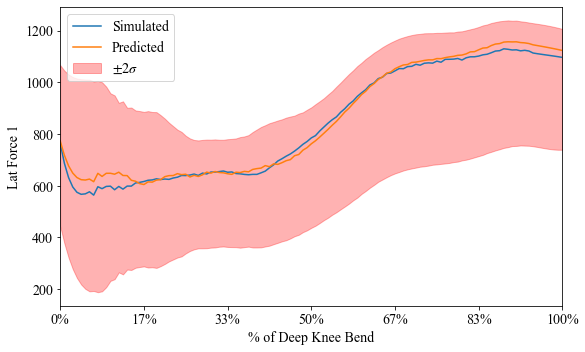

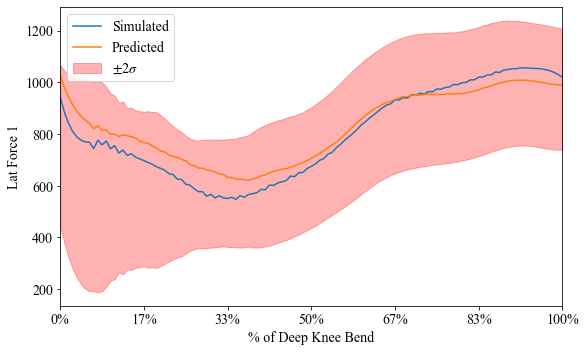

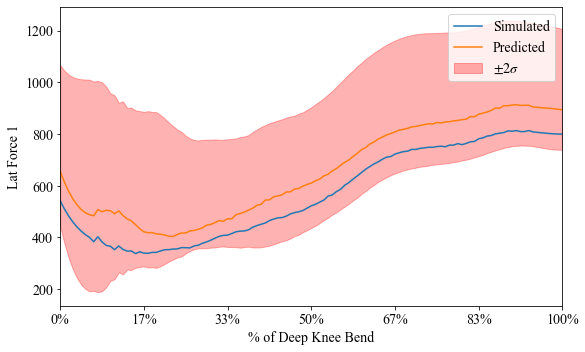

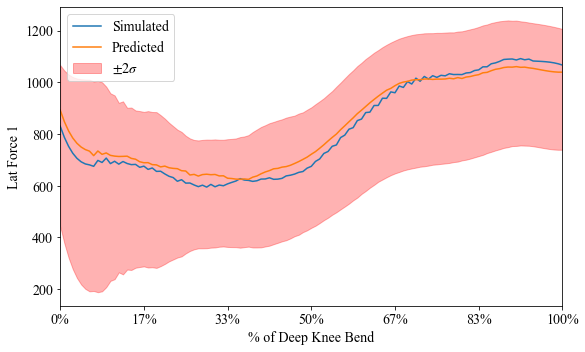

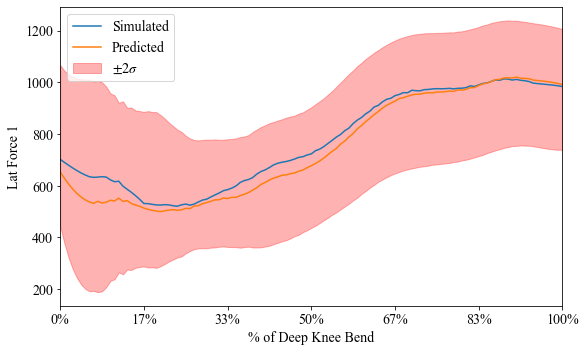

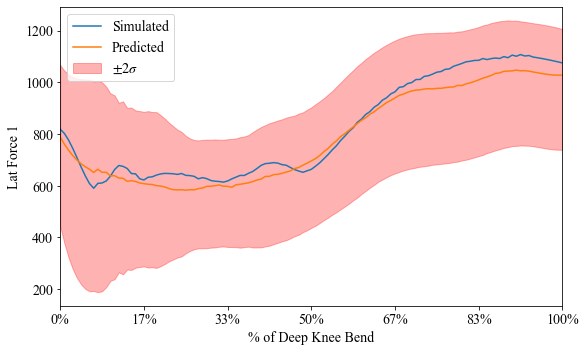

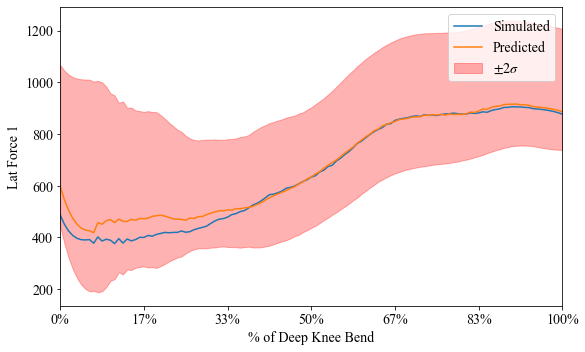

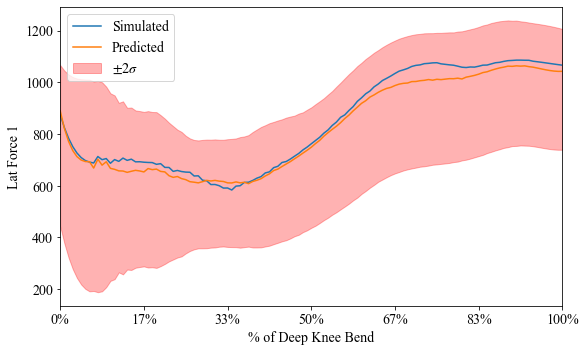

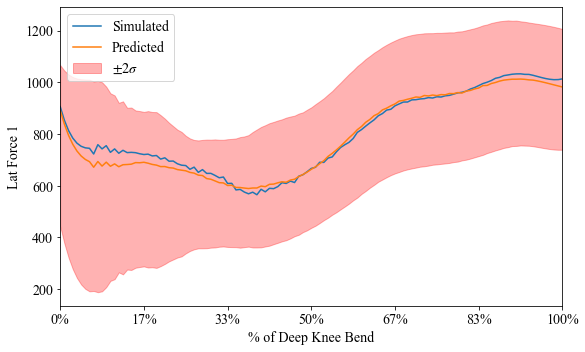

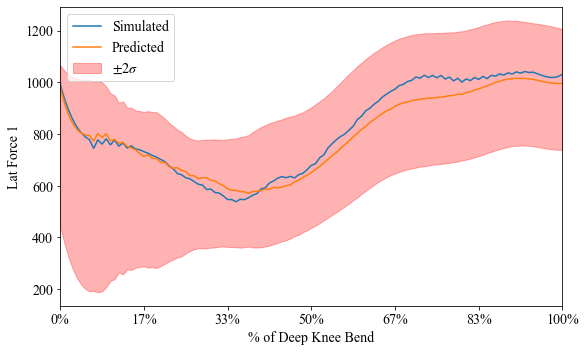

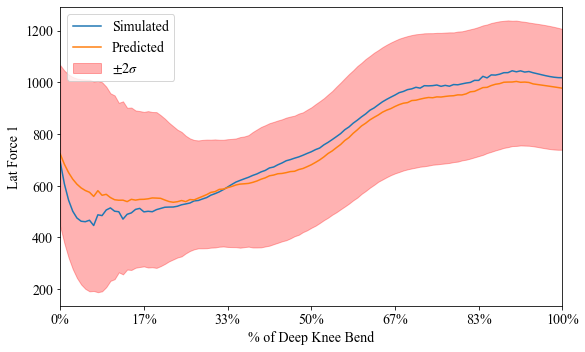

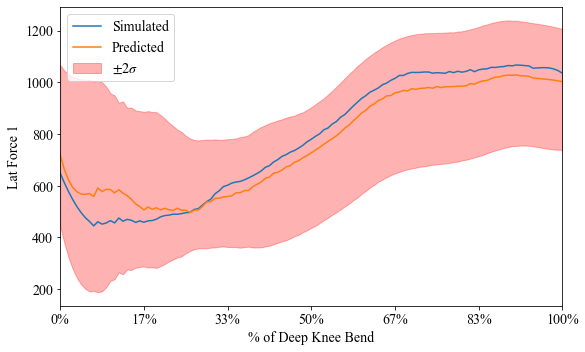

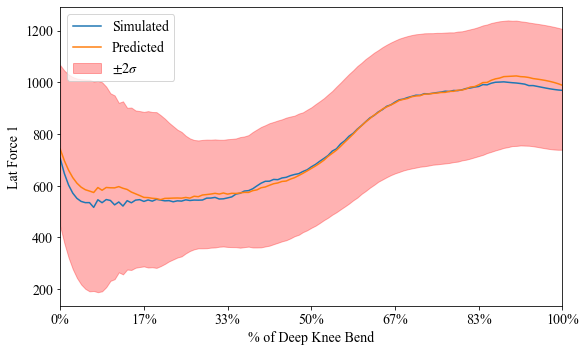

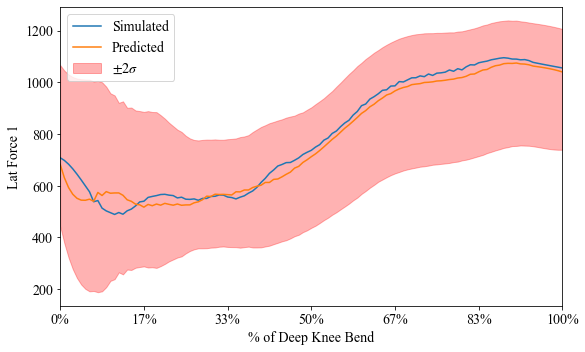

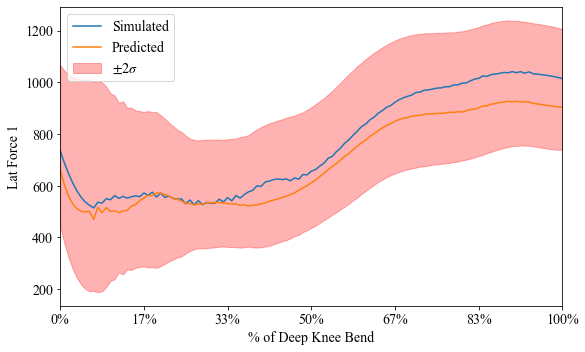

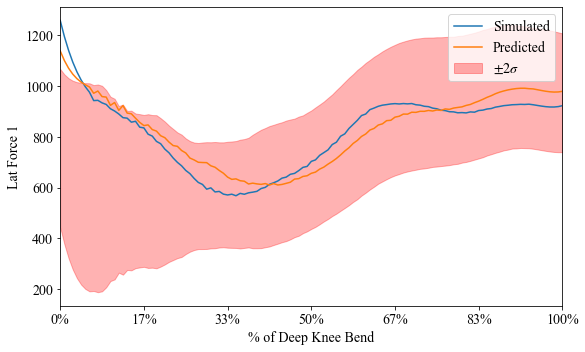

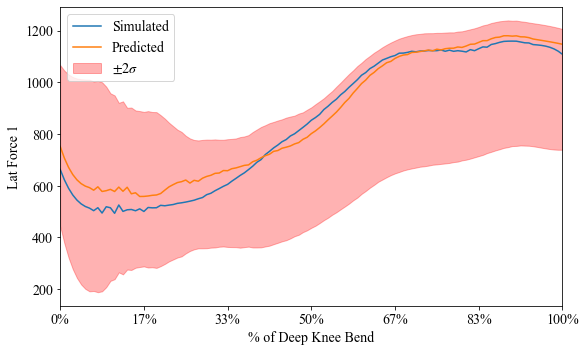

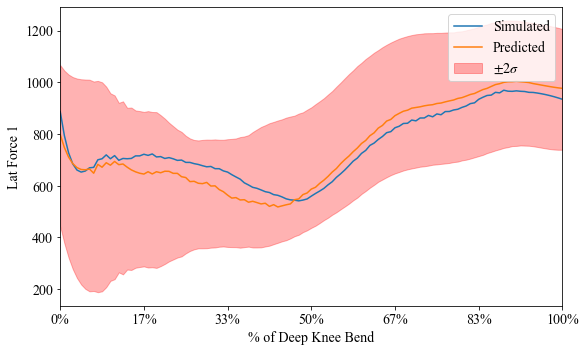

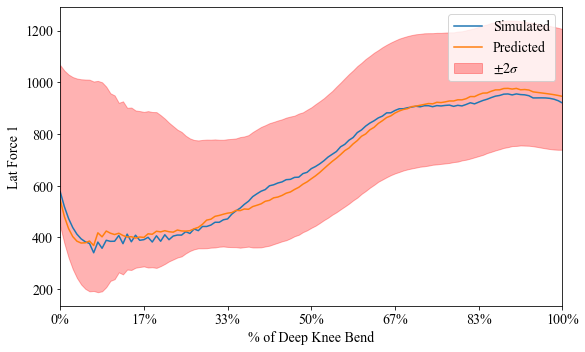

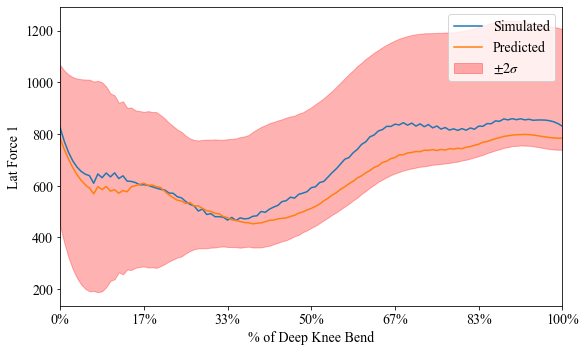

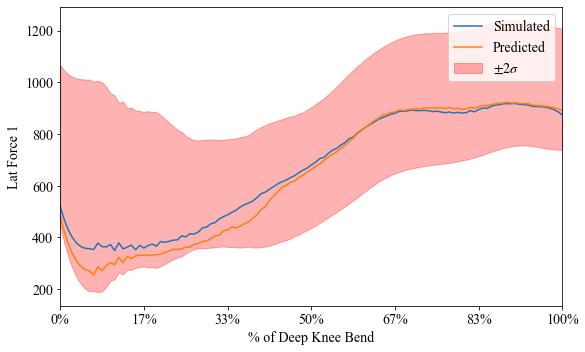

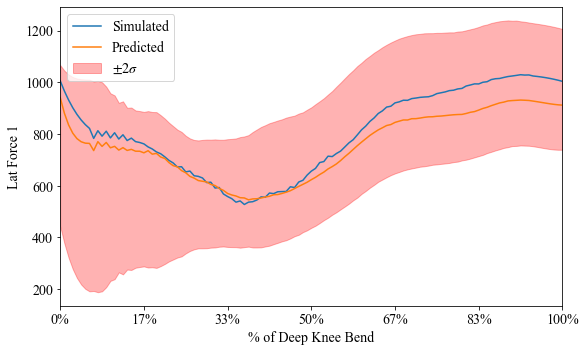

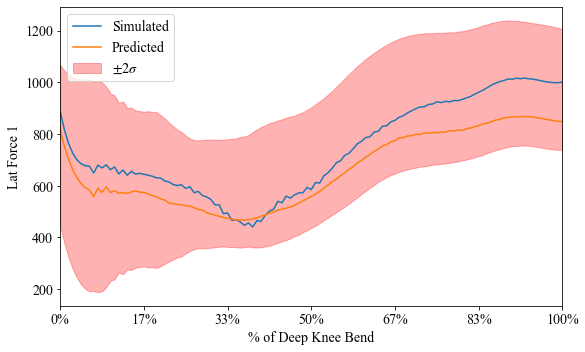

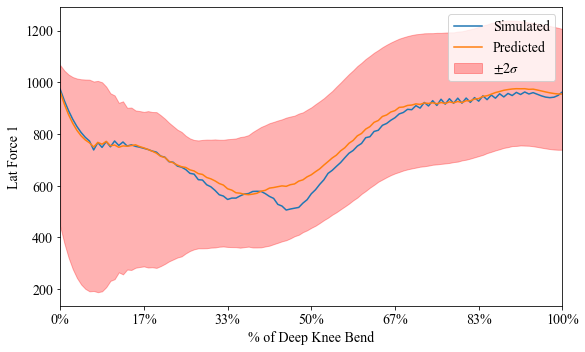

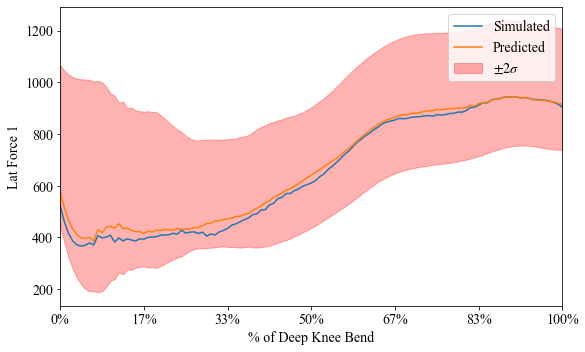

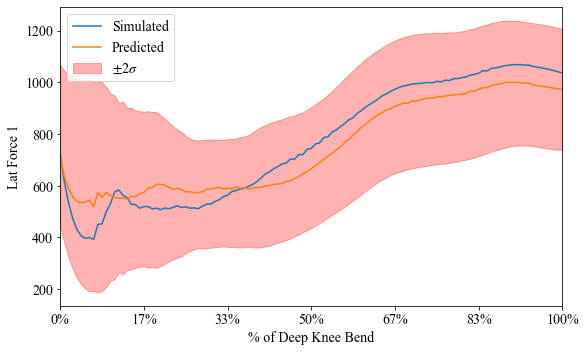

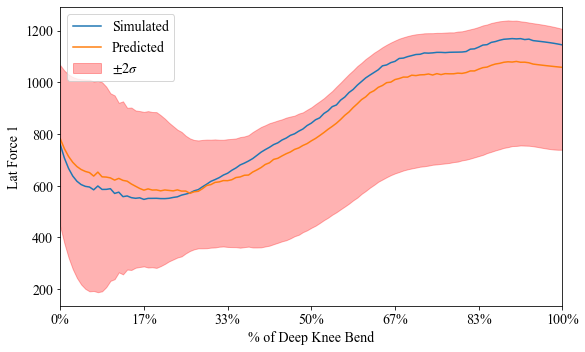

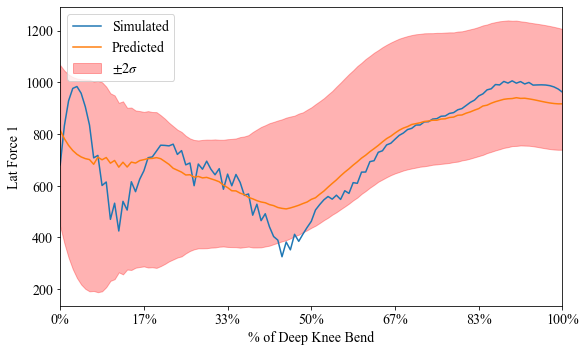

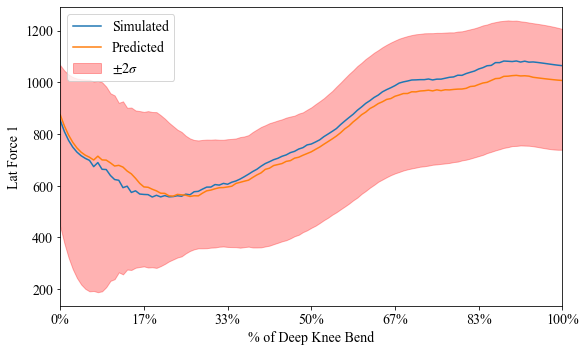

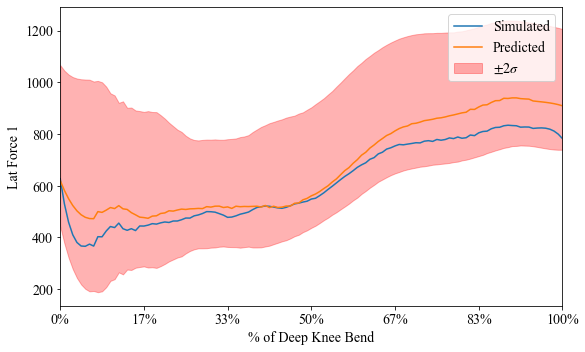

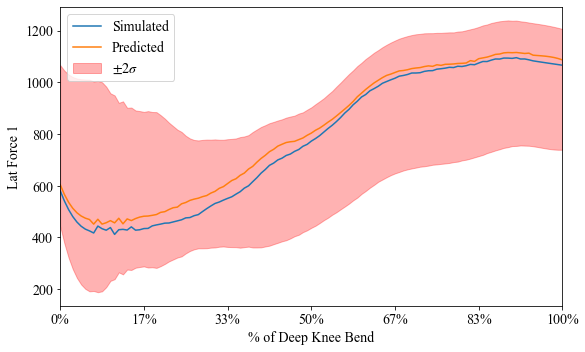

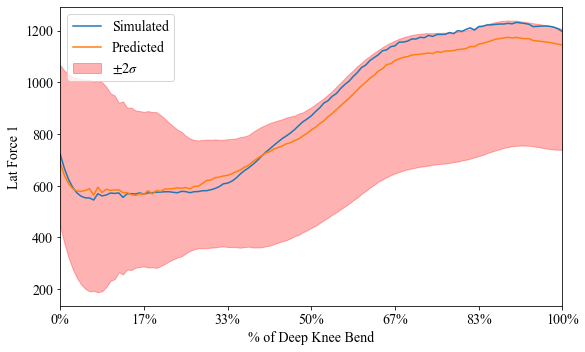

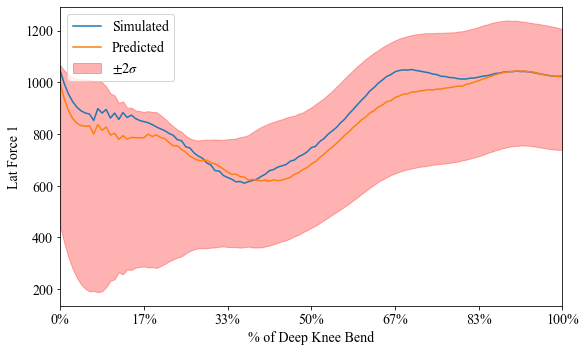

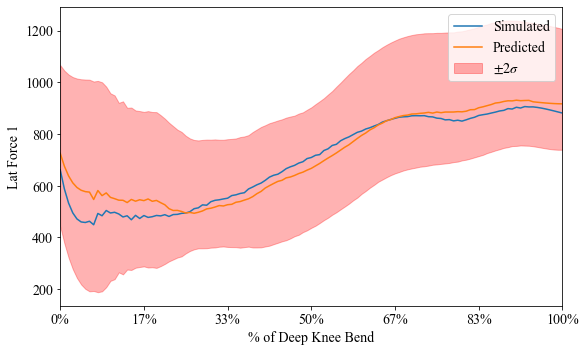

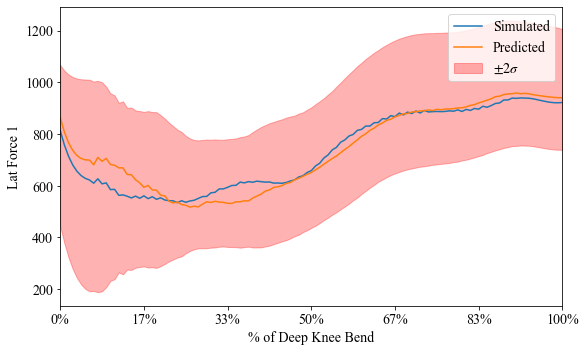

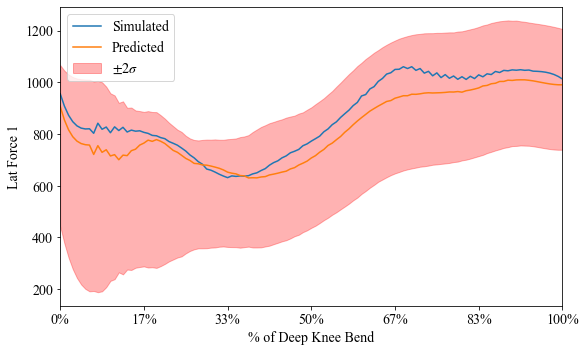

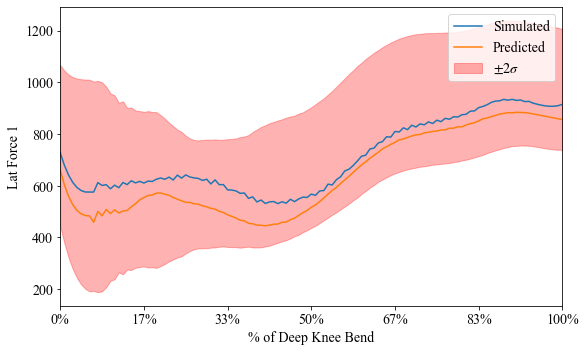

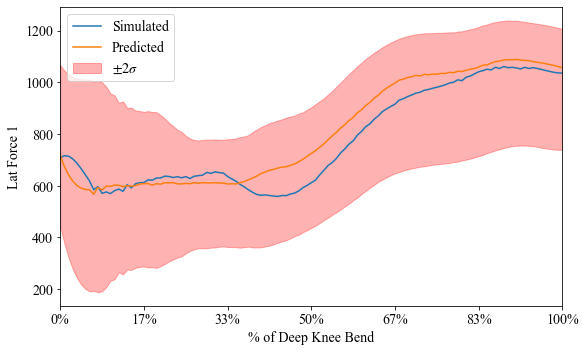

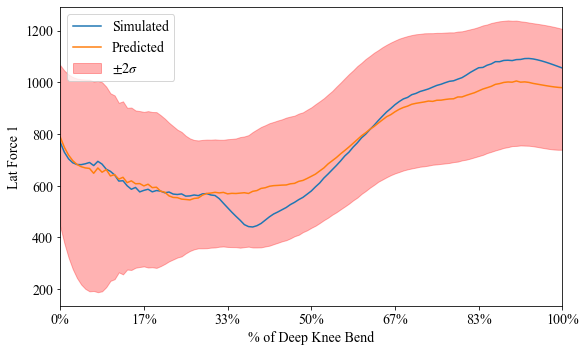

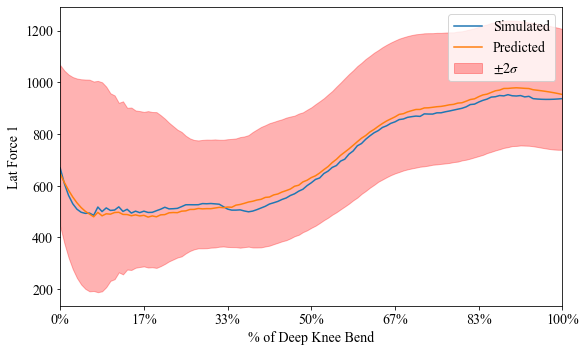

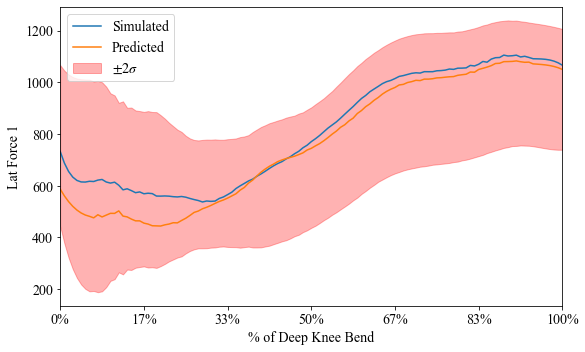

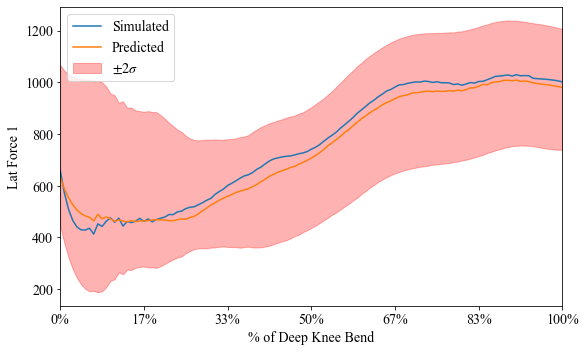

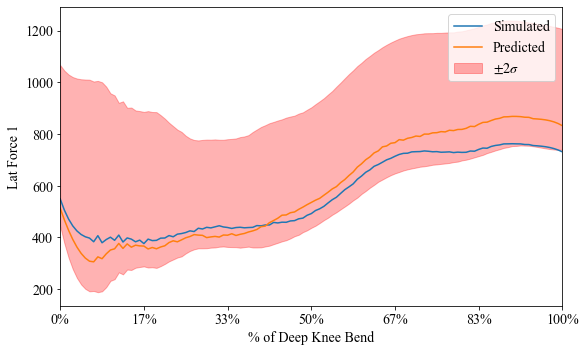

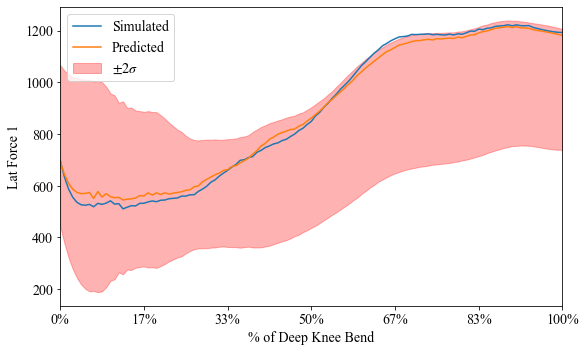

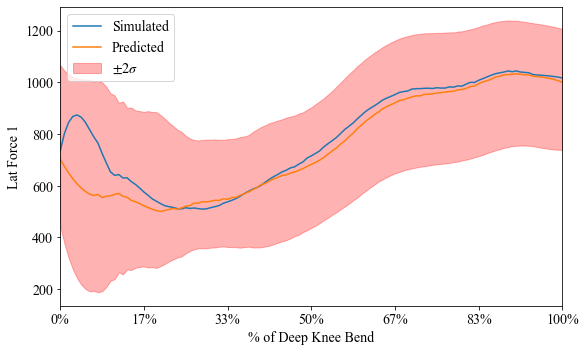

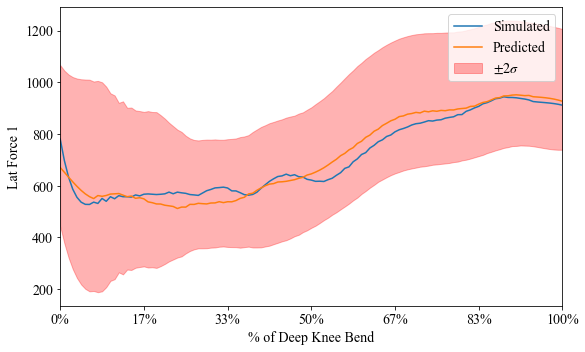

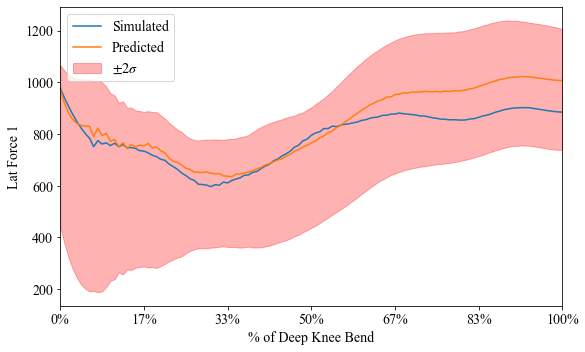

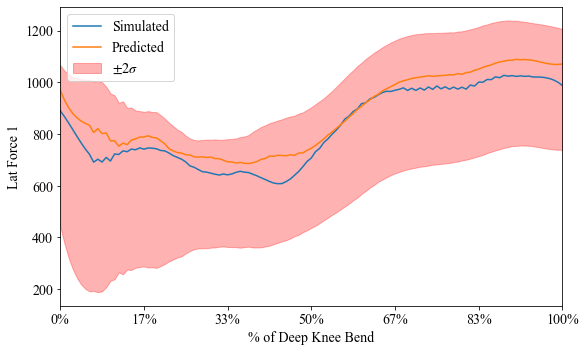

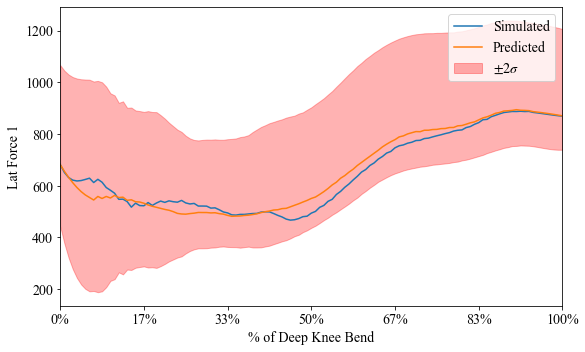

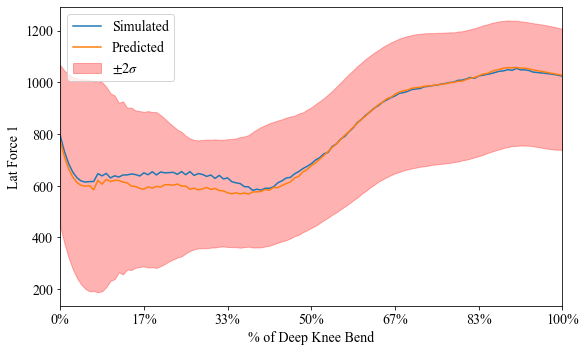

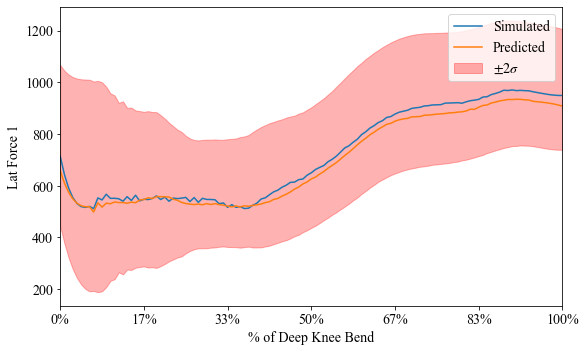

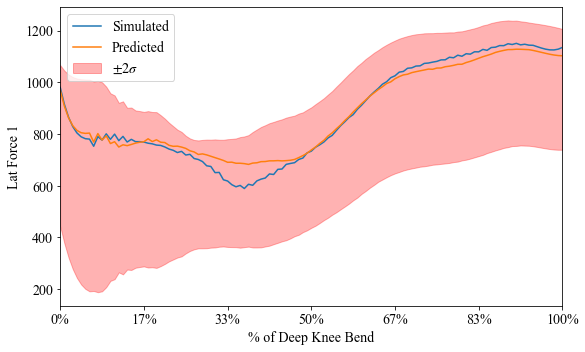

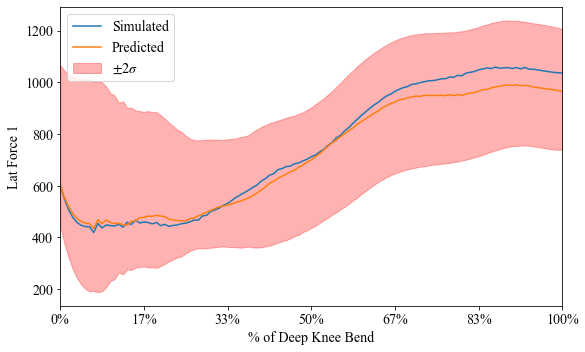

In [ ]:
learner = LinearRegression()
regr = MultiOutputRegressor(learner)
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_test_scaled)


def smooth(array, window=15, poly=3):
    return signal.savgol_filter(array, window, poly)


# Plot the data from the training set, include 95% interval
tim = train_resp_df['time'][0]
avg = smooth(y_train.mean(axis=0))
sd2 = 2 * y_train.std(axis=0)

err = np.zeros(len(y_pred))
for y_t, y_p in zip(y_test, y_pred):
    plt.figure()
    plt.fill_between(tim, smooth(avg - sd2), smooth(avg + sd2),
                     color='r', alpha=0.3, label=r'$\pm 2\sigma$')
    plt.plot(tim, smooth(y_t), label='Simulated')
    plt.plot(tim, smooth(y_p), label='Predicted')
    plt.legend(loc='best')
    plt.xlim((tim.min(), tim.max()))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=tim.max()))
    plt.xlabel('% of Deep Knee Bend')
    plt.ylabel(resp_name.replace('_', ' ').title())



Those look pretty reasonable to me. The next steps would be to check if we can improve the results by performing polynomial transformation on the features. I'll leave that for another time.